## generate line segment chains for testing purposes

Found 7 horizontal contours, and 7 vertical contours
Cross image 2 has been used.


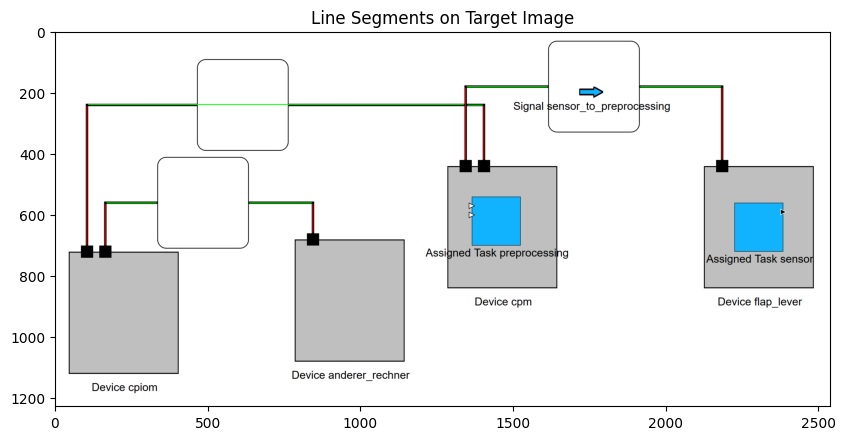

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import random as random

target_image_path = 'images/allocations.png'
target_img = cv2.imread(target_image_path)
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Define custom kernels
kernels_vertical = [
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1)),
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1)),
    np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1))
]
kernels_horizontal = [np.transpose(k) for k in kernels_vertical]

target_gray_temp = target_gray.copy()

result_filter_ver = []
for kernel in kernels_vertical:
    result = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel)
    result_filter_ver.append(result)
result_filter_hor = []
for kernel in kernels_horizontal:
    result = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel)
    result_filter_hor.append(result)
    
combined = np.zeros_like(result_filter_ver[0])
for result in result_filter_ver:
    combined = np.maximum(combined, result)
for result in result_filter_hor:
    combined = np.maximum(combined, result)

# Combine the individual results into single arrays
combined_hor = np.maximum.reduce(result_filter_hor)
combined_ver = np.maximum.reduce(result_filter_ver)

result_filter_hor = combined_hor
result_filter_ver = combined_ver

# Normalize to 0-255 and convert to uint8
result_filter_ver_norm = cv2.normalize(result_filter_ver, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
result_filter_hor_norm = cv2.normalize(result_filter_hor, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

threshold = 230
_, result_filter_ver_thresh = cv2.threshold(result_filter_ver_norm, threshold, 255, cv2.THRESH_BINARY)
_, result_filter_hor_thresh = cv2.threshold(result_filter_hor_norm, threshold, 255, cv2.THRESH_BINARY)

hv_edges_thresh = result_filter_ver_thresh + result_filter_hor_thresh

# Find contours
contours_hor, _ = cv2.findContours(result_filter_hor_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ver, _ = cv2.findContours(result_filter_ver_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Found {len(contours_hor)} horizontal contours, and {len(contours_ver)} vertical contours')

# Draw the contours. Horizontal in blue, vertical in green
contour_img_all = target_img.copy()
# Convert contours to the correct format
contours_hor = [np.array(contour, dtype=np.int32) for contour in contours_hor]
contours_ver = [np.array(contour, dtype=np.int32) for contour in contours_ver]

# Filter out very short contours
min_contour_length = 20
contours_hor_filtered = [c for c in contours_hor if cv2.arcLength(c, False) > min_contour_length]
contours_ver_filtered = [c for c in contours_ver if cv2.arcLength(c, False) > min_contour_length]

def vertical_contours_to_vertical_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the vertical extents by finding min and max y coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        y1, y2 = np.min(y_coords), np.max(y_coords)
        x = np.mean(x_coords).astype(int)  # Assuming vertical, x should be constant
        
        lines.append(((x, y1), (x, y2)))
    
    return lines

def horizontal_contours_to_horizontal_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the horizontal extents by finding min and max x coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        x1, x2 = np.min(x_coords), np.max(x_coords)
        y = np.mean(y_coords).astype(int)  # Assuming horizontal, y should be constant
        
        lines.append(((x1, y), (x2, y)))
    
    return lines

line_segments_ver = vertical_contours_to_vertical_segments(contours_ver_filtered)
line_segments_hor = horizontal_contours_to_horizontal_segments(contours_hor_filtered)

line_segments_hor_sorted = line_segments_hor.copy()
line_segments_hor_sorted.sort(key=lambda seg: (seg[0][0], seg[0][1]))
line_segments_ver_sorted = line_segments_ver.copy()
line_segments_ver_sorted.sort(key=lambda seg: (seg[0][1], seg[0][0]))

# finding intersections
intersections_on_target_img = target_img.copy()
cross_0 = cv2.imread('images/cross_kernel_0.png')
cross_1 = cv2.imread('images/cross_kernel_1.png')
cross_2 = cv2.imread('images/cross_kernel_2.png')

res_0 = cv2.matchTemplate(intersections_on_target_img, cross_0, cv2.TM_CCOEFF_NORMED)
res_1 = cv2.matchTemplate(intersections_on_target_img, cross_1, cv2.TM_CCOEFF_NORMED)
res_2 = cv2.matchTemplate(intersections_on_target_img, cross_2, cv2.TM_CCOEFF_NORMED)

# Find the res variable with the best matches
max_val_0 = cv2.minMaxLoc(res_0)[1]
max_val_1 = cv2.minMaxLoc(res_1)[1]
max_val_2 = cv2.minMaxLoc(res_2)[1]

# Determine which res variable has the highest maximum value
max_vals = [max_val_0, max_val_1, max_val_2]
best_res_index = max_vals.index(max(max_vals))

# Select the best res variable
if best_res_index == 0:
    res = res_0
    print("Cross image 0 has been used.")
elif best_res_index == 1:
    res = res_1
    print("Cross image 1 has been used.")
else:
    res = res_2
    print("Cross image 2 has been used.")

# Threshold the result
threshold = 0.9 # 0.92 or lower results in multiple matches per crossing
loc = np.where(res >= threshold)

# Move the detected crosses 6 pixels to the right and 6 pixels down so the intersections match the center of the cross
# (12 by 12 template)
loc = (loc[0] + 6, loc[1] + 6)

def remove_close_intersections(intersections, proximity=5):
    # Sort intersections by x and then by y to ensure upper left ones come first
    intersections = sorted(intersections, key=lambda pt: (pt[0], pt[1]))
    
    filtered_intersections = []
    while intersections:
        current = intersections.pop(0)
        filtered_intersections.append(current)
        
        # Remove intersections that are within the proximity range
        intersections = [pt for pt in intersections if abs(pt[0] - current[0]) > proximity or abs(pt[1] - current[1]) > proximity]
    
    return filtered_intersections

# Convert loc to a list of tuples
intersections = list(zip(*loc[::-1]))

# Remove close intersections
intersections = remove_close_intersections(intersections, proximity=5)

def find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    x, y = crossing
    closest_ver = sorted(line_segments_ver_sorted, key=lambda seg: min(abs(seg[0][0] - x), abs(seg[1][0] - x)) + tolerance)[:2]
    closest_hor = sorted(line_segments_hor_sorted, key=lambda seg: min(abs(seg[0][1] - y), abs(seg[1][1] - y)) + tolerance)[:2]
    return closest_ver, closest_hor

def merge_lines(closest_ver, closest_hor):
    merged_ver = (min(closest_ver[0][0][1], closest_ver[1][0][1]), max(closest_ver[0][1][1], closest_ver[1][1][1]))
    merged_hor = (min(closest_hor[0][0][0], closest_hor[1][0][0]), max(closest_hor[0][1][0], closest_hor[1][1][0]))
    return merged_ver, merged_hor

def connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    merged_lines = []
    for crossing in crossings:
        closest_ver, closest_hor = find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance)
        
        if len(closest_ver) < 2 or len(closest_hor) < 2:
            continue  # Skip if there are not enough lines to merge
        
        merged_ver, merged_hor = merge_lines(closest_ver, closest_hor)
        
        for line in closest_ver:
            line_segments_ver_sorted.remove(line)
        for line in closest_hor:
            line_segments_hor_sorted.remove(line)
        
        new_ver_line = ((crossing[0], merged_ver[0]), (crossing[0], merged_ver[1]))
        new_hor_line = ((merged_hor[0], crossing[1]), (merged_hor[1], crossing[1]))
        
        line_segments_ver_sorted.append(new_ver_line)
        line_segments_hor_sorted.append(new_hor_line)
        
        merged_lines.append((new_ver_line, new_hor_line))
    
    return line_segments_ver_sorted, line_segments_hor_sorted, merged_lines

line_segments_ver_sorted, line_segments_hor_sorted, merged_lines = connect_lines_at_crossings(intersections, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5)

# Draw the line segments onto the target image
for line in line_segments_ver_sorted:
    cv2.line(target_img, line[0], line[1], (0, 0, 255), 2)  # Red for vertical lines

for line in line_segments_hor_sorted:
    cv2.line(target_img, line[0], line[1], (0, 255, 0), 2)  # Green for horizontal lines

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.title('Line Segments on Target Image')
plt.show()

## convert segment chains to polylines

[[[(2184, 186), (2184, 419)], [(1917, 182), (2180, 182)]], [[(104, 246), (104, 699)], [(109, 240), (1338, 240)], [(1351, 242), (1400, 242)], [(1404, 246), (1404, 419)]], [[(164, 566), (164, 699)], [(169, 562), (332, 562)]], [[(844, 566), (844, 659)], [(637, 562), (840, 562)]], [[(1343, 186), (1343, 419)], [(1349, 182), (1612, 182)]]]


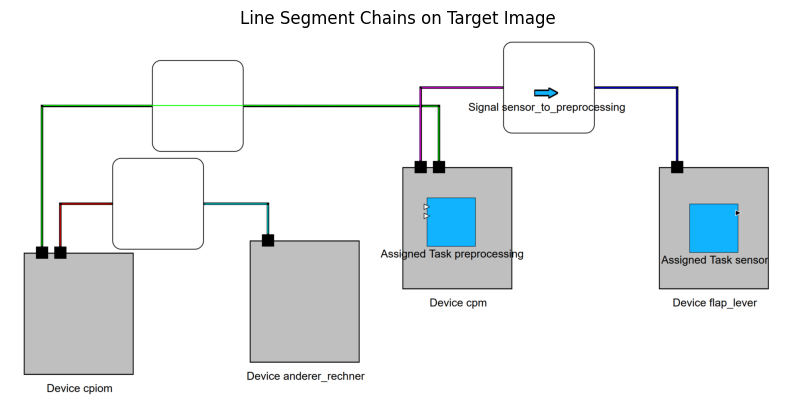

Number of found individual chains: 5


In [12]:
def distance(p1, p2):
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1] 
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

# Convert line segments to regular integers
line_segments_ver_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_ver_sorted
]

line_segments_hor_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_hor_sorted
]

line_segments = line_segments_ver_sorted + line_segments_hor_sorted

max_distance = 20

line_segment_chains = []
used_segments = []

for i, segment1 in enumerate(line_segments):
    if segment1 in used_segments:
        continue
    chain = [segment1]
    used_segments.append(segment1)
    
    chain_growing = True  # Flag to check if the chain is still growing
    while chain_growing:
        chain_growing = False  # Assume no new segments are added in this iteration
        for j, segment2 in enumerate(line_segments):
            if segment2 in used_segments:
                continue

            # Check if the new segment connects to any of the current chain's segments
            for chain_segment in chain:
                if (distance(chain_segment[0], segment2[0]) <= max_distance or
                    distance(chain_segment[0], segment2[1]) <= max_distance or
                    distance(chain_segment[1], segment2[0]) <= max_distance or
                    distance(chain_segment[1], segment2[1]) <= max_distance):
                    
                    chain.append(segment2)
                    used_segments.append(segment2)
                    chain_growing = True  # Keep growing the chain
                    break  # No need to check other chain segments for this one
            if chain_growing:
                break  # If we've added a segment, restart the outer loop

    line_segment_chains.append(chain)

print(line_segment_chains)

# Draw the chains on the image
target_img_with_chains = target_img.copy()
for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for segment in chain:
        cv2.line(target_img_with_chains, segment[0], segment[1], color, 2)

# Display the image with chains
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_chains, cv2.COLOR_BGR2RGB))
plt.title('Line Segment Chains on Target Image')
plt.axis('off')
plt.show()
print(f"Number of found individual chains: {len(line_segment_chains)}")

#### finding endpoints of chains by looking for points with no other points in their proximity

In [13]:
endpoints_of_chains = []
for i, chain in enumerate(line_segment_chains):
    endpoints = []
    for segment in chain:
        for point in segment:
            if all(distance(point, other_point) > max_distance for other_segment in chain for other_point in other_segment if point != other_point):
                endpoints.append(point)
            
    print(f"Chain {i} endpoints: {endpoints}")
    endpoints_of_chains.append(endpoints)

sorted_chains = []
for i, chain in enumerate(line_segment_chains):
    if not endpoints_of_chains[i]:
        sorted_chains.append(chain)
        print(f"Chain {i} has no endpoints, skipping sorting")
        continue
    
    start_point = endpoints_of_chains[i][0]
    sorted_chain = [start_point]
    remaining_segments = chain.copy()
    
    while remaining_segments:
        last_point = sorted_chain[-1]
        next_segment = min(remaining_segments, key=lambda seg: min(distance(last_point, seg[0]), distance(last_point, seg[1])))
        remaining_segments.remove(next_segment)
        
        if distance(last_point, next_segment[0]) < distance(last_point, next_segment[1]):
            if next_segment[0] != last_point:
                sorted_chain.append(next_segment[0])
            sorted_chain.append(next_segment[1])
        else:
            if next_segment[1] != last_point:
                sorted_chain.append(next_segment[1])
            sorted_chain.append(next_segment[0])
    
    sorted_chains.append(sorted_chain)
print(sorted_chains)

Chain 0 endpoints: [(2184, 419), (1917, 182)]
Chain 1 endpoints: [(104, 699), (1404, 419)]
Chain 2 endpoints: [(164, 699), (332, 562)]
Chain 3 endpoints: [(844, 659), (637, 562)]
Chain 4 endpoints: [(1343, 419), (1612, 182)]
[[(2184, 419), (2184, 186), (2180, 182), (1917, 182)], [(104, 699), (104, 246), (109, 240), (1338, 240), (1351, 242), (1400, 242), (1404, 246), (1404, 419)], [(164, 699), (164, 566), (169, 562), (332, 562)], [(844, 659), (844, 566), (840, 562), (637, 562)], [(1343, 419), (1343, 186), (1349, 182), (1612, 182)]]


In [14]:
# Iterate through each chain and create OpenCV polylines
opencv_polylines = []
for chain in sorted_chains:
    polyline = []
    for segment in chain:
        polyline.append(segment[0])
        polyline.append(segment[1])
    opencv_polylines.append(np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)))

for i, polyline in enumerate(opencv_polylines):
    formatted_points = ', '.join([f"({point[0][0]}, {point[0][1]})" for point in polyline])
    print(f"Polyline {i}: {formatted_points}")

Polyline 0: (2184, 419), (2184, 186), (2180, 182), (1917, 182)
Polyline 1: (104, 699), (104, 246), (109, 240), (1338, 240), (1351, 242), (1400, 242), (1404, 246), (1404, 419)
Polyline 2: (164, 699), (164, 566), (169, 562), (332, 562)
Polyline 3: (844, 659), (844, 566), (840, 562), (637, 562)
Polyline 4: (1343, 419), (1343, 186), (1349, 182), (1612, 182)


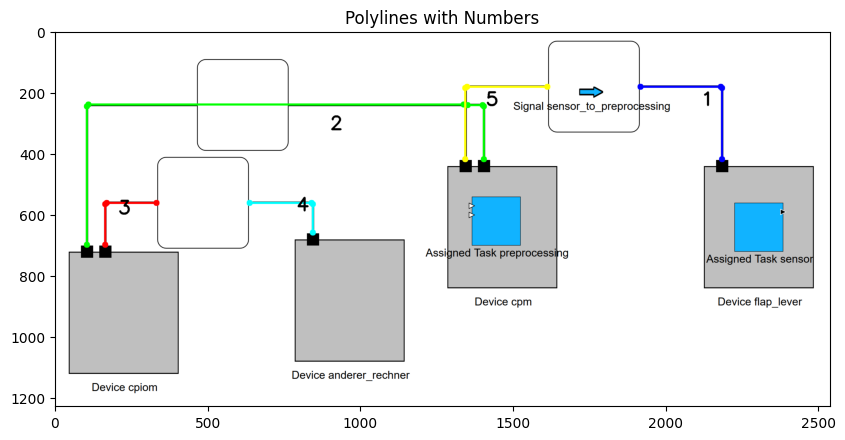

In [15]:
# Filter out None values and convert to integer tuples
filtered_polylines = []
for polyline in opencv_polylines:
    filtered_polyline = [point for point in polyline if point is not None]
    filtered_polylines.append(filtered_polyline)

# Define colors for the polylines
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)

# Draw the lines on the target_img.copy()
target_img_with_polylines = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(target_img_with_polylines, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(target_img_with_polylines, tuple(point.squeeze()), 10, color, -1)

# Print the number of each polyline on the image
for i, polyline in enumerate(opencv_polylines):
    # Calculate the center of the polyline for placing the text
    center_x = int(np.mean(polyline[:, 0, 0]))
    center_y = int(np.mean(polyline[:, 0, 1]))
    cv2.putText(target_img_with_polylines, str(i + 1), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

# Plot the polylines with numbers
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
plt.title('Polylines with Numbers')
plt.show()